# Self-Driving Car Engineer Nanodegree

## Topic   : Deep Learning

## Project : Traffic Sign Recognition Classifier


## Dataset Exploration

In [11]:
#Imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import pickle
import csv
import collections
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import train_test_split
import time
from datetime import timedelta
import math
import cv2
import matplotlib.gridspec as gridspec
import os
import random


In [12]:
# Load pickled data
TrainingFile = "../traffic-signs-data/train.p"
TestingFile  = "../traffic-signs-data/test.p"
LabelsFile   = "../traffic-signs-data/signnames.csv"
with open(TrainingFile, mode='rb') as f:
    TrainingData = pickle.load(f)
with open(TestingFile, mode='rb') as f:
    TestingData = pickle.load(f)
with open(LabelsFile,mode='r') as csvfile:
    csvreader=csv.reader(csvfile)
    Labels=list(csvreader)
#Load into Arrays    
TrainFeatures, TrainLabels = TrainingData['features'], TrainingData['labels']
TestFeatures , TestLabels  = TestingData['features'] , TestingData['labels']


German Traffic Signs- Data Set Details
Number of training examples = 39209
Number of testing  examples = 12630
Number of classes           = 43
Max # of Signs              = 2250 with label Speed limit (50km/h)
Min # of Signs              = 210  with label Speed limit (20km/h)


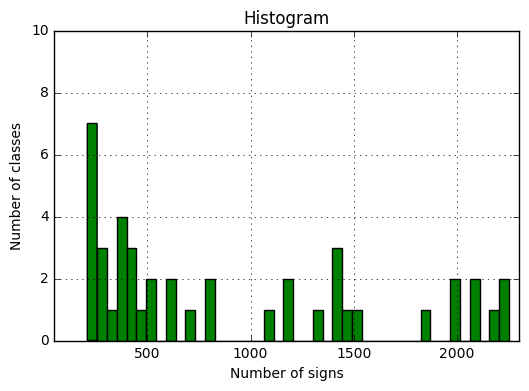

In [13]:
# Number of training,testing examples and classes
NumTrainSam = len(TrainFeatures)
NumTestSam  = len(TestFeatures)
NumClasses  = len(Labels)
#Data Exploration
#1. Count number of images in each class
ClassCount=collections.Counter(TrainLabels)
#2. Min and Max Signs
maxkey=max(ClassCount,key=ClassCount.get) # Index with max number of signs
minkey=min(ClassCount,key=ClassCount.get) # Index with min number of signs
maxnum=ClassCount[maxkey]
minnum=ClassCount[minkey]
#Convert to list. ClassList has number of images for each class
ClassList=[]
for key, values in ClassCount.items():
    ClassList.append(values)
#Print the details
print("German Traffic Signs- Data Set Details")
print("Number of training examples =", NumTrainSam)
print("Number of testing  examples =", NumTestSam)
print("Number of classes           =", NumClasses)
print("Max # of Signs              = "+str(maxnum)+" with label "+str(Labels[maxkey][1]))
print("Min # of Signs              = "+str(minnum)+"  with label "+str(Labels[minkey][1]))

#Plot the histogram
plt.figure()
plt.title('Histogram')
plt.xlabel('Number of signs')
plt.ylabel('Number of classes')
plt.grid(True)
plt.axis([50,2300,0,10])
n, bins, patches = plt.hist(ClassList, NumClasses ,facecolor='green')



In [14]:
#Calculate data that needs to be generated and store it in ToGenNum list
ToGenNum=[]
#Print all classes
print("\n{:<55}{:<10}{:>20}".format("Traffic Sign","In Dataset","To be Generated"))
for i in range(0,NumClasses):
    String=str("{:<55}".format(Labels[i][1]))+"{:<10}".format(str(ClassList[i]))\
    +"{:>20}".format(str(maxnum-ClassList[i]))
    print(String)
    ToGenNum.append(maxnum-ClassList[i])

TotalNewData2Gen=sum(ToGenNum)
TotalDataSize=NumTrainSam+TotalNewData2Gen
print("\nTotal Data to be generated: "+str(TotalNewData2Gen))
print("Size of Total Dataset after new data is generated: "+str(TotalDataSize))


Traffic Sign                                           In Dataset     To be Generated
Speed limit (20km/h)                                   210                       2040
Speed limit (30km/h)                                   2220                        30
Speed limit (50km/h)                                   2250                         0
Speed limit (60km/h)                                   1410                       840
Speed limit (70km/h)                                   1980                       270
Speed limit (80km/h)                                   1860                       390
End of speed limit (80km/h)                            420                       1830
Speed limit (100km/h)                                  1440                       810
Speed limit (120km/h)                                  1410                       840
No passing                                             1470                       780
No passing for vechiles over 3.5 metric tons         

In [15]:
#Idea is to generate same random numbers so we can compare results after preprocessing
RandState=random.getstate() #Store randstate to get same results everytime

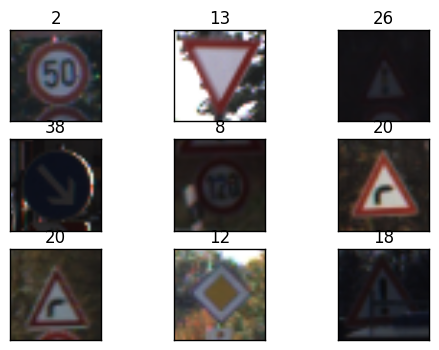

In [16]:
#Plot Random Images. 
def pltRandImages(ImgArray,ImgLabels,Rows=2):
    pltIndex=0;
    ImgIndex=0;
    gs=gridspec.GridSpec(Rows,Rows)
    random.setstate(RandState)
    ImgIndex=random.sample(range(len(ImgArray)),Rows*Rows)
    for i in range (0,Rows*Rows):
        if(pltIndex>Rows-1):
            pltIndex=0
        ax=plt.subplot(gs[int(i/Rows),pltIndex])
        ax.set_xticks([])
        ax.set_yticks([])
        plt.title(ImgLabels[ImgIndex[i]])
        plt.imshow(ImgArray[ImgIndex[i]])
        pltIndex=pltIndex+1
pltRandImages(TrainFeatures,TrainLabels,3)

## Step 2: Design and Test a Model Architecture

### Question 1 

_Describe the techniques used to preprocess the data._


Data Augmentation.

From the histogram in data exploration stage we find that large number of classes are on left side of histogram showing that they are under represented. Using training data as is will make the network perform poorly on under represented traffic signs. So I generated new data, by rotating and translating images, of each class such that their number is equal to number of images in class with highest number of images.

Pre Processing 

Images were first adjusted for global constrast using histogram equalization. Then local contrast equaliztion is done using contrast limited adaptive histogram equalization.

### 1. Augmenting Training Data


In [17]:
GenShape=(TotalNewData2Gen,32,32,3) #Shape of array to hold generated data
TrainFeaturesGen=np.zeros(GenShape,TrainFeatures.dtype)     #Array to hold generated images
TrainLabelsGen=np.zeros(TotalNewData2Gen,TrainLabels.dtype) #Array to hold generated labels

# Generate to be generated number of random index from each class
RandImgIndex=[]
Count=0
for i in range(0,NumClasses):
    RandImgIndex.append(np.random.randint(Count,Count+ClassList[i],ToGenNum[i]))
    Count=Count+ClassList[i]

#Generating Augmented Data by Rotating, Scaling and Changing Positions
#Values are from Paper (Traffic Sign Recognition with Multi-Scale Convolutional Networks)
IndexCount=0
for i in range(0,NumClasses):
    print("Generating "+str(ToGenNum[i])+" "+str(Labels[i][1])+" features and labels")
    for j in range(0,ToGenNum[i]):
        Image=TrainFeatures[RandImgIndex[i][j]]
        #Rotation
        MaxRotAngle=15
        rows,cols,chnls=Image.shape
        RotMatrix=cv2.getRotationMatrix2D((rows/2,cols/2),random.uniform(-MaxRotAngle,MaxRotAngle),1)
        Image=cv2.warpAffine(Image,RotMatrix,(rows,cols))
        #Translation
        TransMatrix=np.float32([[1,0,random.uniform(-2,2)],[0,1,random.uniform(-2,2)]])
        Image=cv2.warpAffine(Image,TransMatrix,(rows,cols))
        #Scale
        #Image=cv2.resize(Image,None,fx=random.uniform(0.9,1.1),fy=random.uniform(0.9,1.1),interpolation=cv2.INTER_CUBIC)
        TrainFeaturesGen[IndexCount]=Image
        TrainLabelsGen[IndexCount]=i
        IndexCount=IndexCount+1


Generating 2040 Speed limit (20km/h) features and labels
Generating 30 Speed limit (30km/h) features and labels
Generating 0 Speed limit (50km/h) features and labels
Generating 840 Speed limit (60km/h) features and labels
Generating 270 Speed limit (70km/h) features and labels
Generating 390 Speed limit (80km/h) features and labels
Generating 1830 End of speed limit (80km/h) features and labels
Generating 810 Speed limit (100km/h) features and labels
Generating 840 Speed limit (120km/h) features and labels
Generating 780 No passing features and labels
Generating 240 No passing for vechiles over 3.5 metric tons features and labels
Generating 930 Right-of-way at the next intersection features and labels
Generating 150 Priority road features and labels
Generating 90 Yield features and labels
Generating 1470 Stop features and labels
Generating 1620 No vechiles features and labels
Generating 1830 Vechiles over 3.5 metric tons prohibited features and labels
Generating 1140 No entry features 

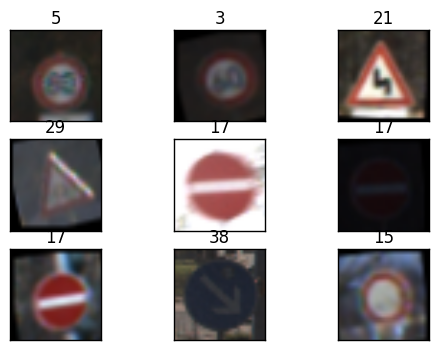

In [18]:
#Accumulating Generated Data with Original Data
TrainFeatures=np.append(TrainFeatures,TrainFeaturesGen,axis=0)
TrainLabels=np.append(TrainLabels,TrainLabelsGen)
pltRandImages(TrainFeatures,TrainLabels,3)

### 2. Pre Processing Data

In [21]:
#Pre Processing all the Images now
def preProcess(Img):
    Image=Img
    #Global Histogram Equilization
    Image[:,:,0]=cv2.equalizeHist(Image[:,:,0])
    Image[:,:,1]=cv2.equalizeHist(Image[:,:,1])
    Image[:,:,2]=cv2.equalizeHist(Image[:,:,2])
    #Local Histogram Equilization
    clahe=cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    Image[:,:,0]=clahe.apply(Image[:,:,0])
    Image[:,:,1]=clahe.apply(Image[:,:,1])
    Image[:,:,2]=clahe.apply(Image[:,:,2])
    return Image
#Pre Processing Training Image
TrainFeaturesPP=np.zeros(TrainFeatures.shape,TrainFeatures.dtype)
for i in range(0,len(TrainFeatures)):
    TrainFeaturesPP[i]=preProcess(TrainFeatures[i])


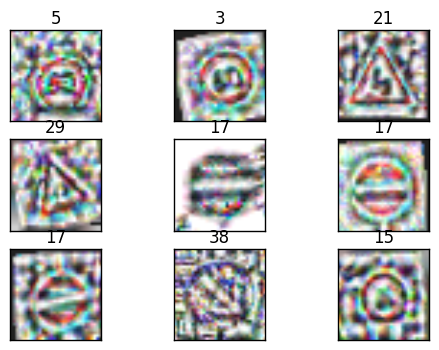

In [24]:
#Plotting Training Images after pre-processing
pltRandImages(TrainFeaturesPP,TrainLabels,3)

In [ ]:
#Splitting into Train and Validation Sets
ValSize=0.1 #10%
XTrainTotal, XValTrain, YTrainTotal, YValTrain = train_test_split(
     XTrainTotal,YTrainTotal, test_size=ValSize, random_state=0)
assert((XValTrain.shape[0]+XTrainTotal.shape[0])==TotalDataSize)

In [ ]:
#Convert Labels into One hot encoded Labels
def LabelEncoder(Labels,NumLabels):
    """Takes in Normal labels and returns onehot encoded labels"""
    Encoder=OneHotEncoder()
    Encoder.fit(np.arange(NumLabels).reshape(-1,1))
    EncodedLabels=Encoder.transform(Labels.reshape(-1,1)).toarray()
    return EncodedLabels
YTrainOHE=LabelEncoder(YTrainTotal,n_classes)
YValOHE  =LabelEncoder(YValTrain,n_classes)
YTestOHE =LabelEncoder(y_test,n_classes)

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:** 
1. Synthetic Data:
From histogram in data exploration stage we find that large number of classes are on left side of histogram showing that they are under represented. Using training data as is will make the network perform poorly on under represented traffic signs. So I generated new data, by rotating and translating images, of each class such that their number is equal to number of images in class with highest number of images.

2. 10% of training dataset is set aside for validation. Test Dataset is left as is.

In [ ]:
#Layer Helper Functions for CNN
def CreateConvLayer(input,NumChnls,FilSize,NumFils,Stride=1):
    #Create shape of filter
    FilterShape=[FilSize,FilSize,NumChnls,NumFils]
    #Create variables for weights and Biases
    Weights=tf.Variable(tf.truncated_normal(FilterShape,stddev=0.05))
    Biases=tf.Variable(tf.constant(0.05,shape=[NumFils]))
    #Convolution Output
    ConvOpt=tf.nn.conv2d(input=input,filter=Weights,strides=[1,Stride,Stride,1],padding='SAME')
    #Add ConvOpt to Biases
    LayerOpt=tf.nn.bias_add(ConvOpt,Biases)
    LayerOpt=tf.nn.relu(LayerOpt)
    return LayerOpt,Weights

def MaxPool2d(x, k=2,stride=2):
    return tf.nn.max_pool(x,ksize=[1, k, k, 1],strides=[1, stride, stride, 1],padding='VALID')
     

#Reshape Conv Layer to input FC Layer
def ConvLayerReshape(layer):
    LayerShape=layer.get_shape()
    NumFeatures =LayerShape[1:4].num_elements()
    LayerFlat=tf.reshape(layer,[-1,NumFeatures])
    return LayerFlat,NumFeatures
#Fully Connected Layer
def CreateFCLayer(input,NumInputs,NumOutputs):
    #Weight Shape
    WShape=[NumInputs,NumOutputs]
    #Create Variables for Weights and Biases
    Weights=tf.Variable(tf.truncated_normal(WShape,stddev=0.05))
    Biases=tf.Variable(tf.constant(0.05,shape=[NumOutputs]))
    #Calculate FC
    FCLayer=tf.matmul(input,Weights)+Biases
    return FCLayer

In [ ]:
#PlaceHolders for color and Gray Images
#Color
ImgPHC=tf.placeholder(tf.float32,[None,X_train.shape[1],X_train.shape[2],X_train.shape[3]])
#Placeholders for Labels
yOHE=tf.placeholder(tf.float32,[None,n_classes])
yNormal=tf.placeholder(tf.float32,[None])



In [ ]:
def AlexNet(x):
    FilterSize=[5,5,3,3,3]
    NumFilters=[24,64,96,96,64]
    FCSize=[512,256,128]
    #Layer1
    L1Conv, L1ConvWeight=CreateConvLayer(x,X_train.shape[3],FilterSize[0],NumFilters[0])
    L1Conv=tf.nn.relu(L1Conv)
    L1Conv=tf.nn.lrn(L1Conv,depth_radius=2,bias=1.0,alpha=2e-05,beta=0.75)
    L1Conv=MaxPool2d(L1Conv)

    #Layer2
    L2Conv, L2ConvWeight =CreateConvLayer(L1Conv,NumFilters[0],FilterSize[1],NumFilters[1])
    L2Conv=tf.nn.relu(L2Conv)
    L2Conv=tf.nn.lrn(L2Conv,depth_radius=2,bias=1.0,alpha=2e-05,beta=0.75)
    L2Conv=MaxPool2d(L2Conv)
    
     
    #Layer3
    L3Conv, L3ConvWeight =CreateConvLayer(L2Conv,NumFilters[1],FilterSize[2],NumFilters[2])
    L3Conv=tf.nn.relu(L3Conv)
    #Layer4
    L4Conv, L4ConvWeight =CreateConvLayer(L3Conv,NumFilters[2],FilterSize[3],NumFilters[3])
    L4Conv=tf.nn.relu(L4Conv)
    #Layer5
    L5Conv, L5ConvWeight =CreateConvLayer(L4Conv,NumFilters[3],FilterSize[4],NumFilters[4])
    L5Conv=tf.nn.relu(L5Conv)
    L5Conv=MaxPool2d(L5Conv)
    
    #Flatten
    FCFlat=flatten(L5Conv)
    
    #FC1
    FC1=CreateFCLayer(FCFlat,1024,FCSize[1])
    FC1=tf.nn.relu(FC1)
    FC1=tf.nn.dropout(FC1,0.5)
    FC2=CreateFCLayer(FC1,FCSize[1],FCSize[2])
    FC2=tf.nn.relu(FC2)
    #FC2=tf.nn.dropout(FC2,0.001)
    FC3=CreateFCLayer(FC2,FCSize[2],n_classes)
    return FC3
    

In [ ]:
#Network Architecture
#Create a CNN
def LeNet(x):
    #Network Parameters
    FilterSize=[5,5]
    NumFilters=[6,16]
    #FullyConnected Parameters
    FCSize=[400,120]
    #Layer1
    L1Conv, L1ConvWeight =CreateConvLayer(x,X_train.shape[3],FilterSize[0],NumFilters[0])
    L1Conv=tf.nn.relu(L1Conv)
    L1Conv=MaxPool2d(L1Conv)
    #Layer2
    L2Conv, L2ConvWeight =CreateConvLayer(L1Conv,NumFilters[0],FilterSize[1],NumFilters[1])
    L2Conv=tf.nn.relu(L2Conv)
    L2Conv=MaxPool2d(L2Conv)
    #Reshape
    FCFlat=flatten(L2Conv)
    #FC
    FC1=CreateFCLayer(FCFlat,1024,512)
    #Do Relu
    FC1Relu=tf.nn.relu(FC1)
    FC2=CreateFCLayer(FC1Relu,512,128)
    FC2Relu=tf.nn.relu(FC2)
    FC3=CreateFCLayer(FC2Relu,128,n_classes)
    return FC3


In [ ]:
FC3=AlexNet(ImgPHC)
ClassPredOHE = tf.nn.softmax(FC3)
ClassPred    = tf.argmax(ClassPredOHE, dimension=1)
ClassPred    = tf.cast(ClassPred,tf.float32)

#Optimization
CrossEntorpy = tf.nn.softmax_cross_entropy_with_logits(logits=FC3,labels=yOHE)
Cost = tf.reduce_mean(CrossEntorpy)
Optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(Cost)

#Accuracy
CorrectPred = tf.equal(ClassPred,yNormal)
Accuracy = tf.reduce_mean(tf.cast(CorrectPred, tf.float32))

In [ ]:
#TensorFlow Save 
Saver = tf.train.Saver()
SaveDir='Checkpoints/'
#Create Savedir if it doesnt exist
if not os.path.exists(SaveDir):
    os.makedirs(SaveDir)
SavePath = SaveDir + 'best_validation'

In [ ]:
test_batch_size=1000
BestValAcc = 0.0 # Best validation accuracy seen so far.
LastImp    = 0      #Last Improvement
ReqImpin   = 1000  #Require improvement in
TotalIter=0
def TrainCNN(NumRuns,BatchSize):
    print("Training Started")
    global TotalIter
    global BestValAcc
    global LastImp
    global BestTestAcc
    StTime=time.time()
    
    for i in range(TotalIter,TotalIter + NumRuns):
        TotalIter +=1
        #Choose Batch size number of indices randomly
        Ind=np.random.choice(len(XTrainTotal),BatchSize,False)
        #Feed Data
        x_batch, y_true_batch,yLabel = XTrainTotal[Ind,:], YTrainOHE[Ind,:], YTrainTotal[Ind]
        feed_dict_train = {ImgPHC: x_batch,
                           yOHE: y_true_batch}
        feed_dict_acc_train={ImgPHC: x_batch,
                           yOHE: y_true_batch,
                            yNormal:yLabel}
        #Run Optimizer
        session.run(Optimizer, feed_dict=feed_dict_train)        
        
        if ((TotalIter%500==0) or (i==(NumRuns-1))):
            #Calculate Training accuracy
            AccTrain=session.run(Accuracy, feed_dict=feed_dict_acc_train)
            #Calculate Validation accuracu
            AccVal=CalcValAcc()
            TestAcc=print_test_accuracy()
            if(AccVal>BestValAcc):
                #Update Fields
                BestValAcc=AccVal
                LastImp=TotalIter
                #Save Session
                Saver.save(sess=session,save_path=SavePath)
                ImpStr="*"
            else:
                ImpStr=""
            msg = "Iter: {0:>6}, Train-Batch Accuracy: {1:>6.1%}, Validation Acc: {2:>6.1%} {3} Test Acc:{4:>4.1%}"
            print(msg.format(i + 1, AccTrain, AccVal, ImpStr,TestAcc))
        # If no improvement found in the required number of iterations.
        if TotalIter - LastImp > ReqImpin:
            print("No improvement found in a while, stopping optimization.")
            break
    # Ending time.
    EndTime = time.time()
    # Difference between start and end-times.
    TimeDelta = EndTime - StTime
    print("Time usage: " + str(timedelta(seconds=int(round(TimeDelta)))))
#Prediction Function
TrainBatchSize=1000
def PredictSign(Images,LabelsOHE,Labels):
    NumImgs=len(Images)
    ClsPred=np.zeros(shape=NumImgs,dtype=np.int)
    i=0
    while i<NumImgs:
        j=min(i+TrainBatchSize,NumImgs)
        feed_dict={ImgPHC:Images[i:j,:],
                  yOHE:LabelsOHE[i:j,:]}
        ClsPred[i:j]=session.run(ClassPred,feed_dict)
        i=j
    Correct=(Labels==ClsPred)
    return Correct
def CalcValAcc():
    Crct=PredictSign(XValTrain,YValOHE,YValTrain)
    CrctSum=Crct.sum()
    Acc=float(CrctSum)/len(Crct)
    return Acc
def CalcTestAcc():
    Crct=PredictSign(XTestG,YTestOHE,y_test)
    CrctSum=Crct.sum()
    Acc=float(CrctSum)/len(Crct)
    return Acc

def print_test_accuracy(show_example_errors=False,show_confusion_matrix=False,Print=0):
    num_test = len(y_test)
    cls_pred = np.zeros(shape=num_test, dtype=np.int)    
    i = 0
    while i < num_test:
        j = min(i + test_batch_size, num_test)
        images = XTestY[i:j, :]
        labels = YTestOHE[i:j, :]
        feed_dict = {ImgPHC: images,yOHE: labels}
        cls_pred[i:j] = session.run(ClassPred, feed_dict=feed_dict)
        i = j
    cls_true = y_test
    correct = (cls_true == cls_pred)
    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()
    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test
    # Print the accuracy.
    if(Print):
        msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
        print(msg.format(acc, correct_sum, num_test))
    return acc

In [ ]:
session = tf.Session()
session.run(tf.global_variables_initializer())

In [ ]:
print_test_accuracy()

In [ ]:
BatchSize=1000 
TrainCNN(15000,BatchSize)

In [ ]:
print_test_accuracy()

In [ ]:
def ClassifyImg(ImgName):
    dim=(32,32)
    Image=cv2.imread(ImgName)
    Image=cv2.cvtColor(Image,cv2.COLOR_BGR2YUV)
    Image=cv2.resize(Image,dim,cv2.INTER_CUBIC)
    clahe=cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    Image[0]=cv2.equalizeHist(Image[0])
    Image[0]=clahe.apply(Image[0])    
    TestDict={ImgPHC:[Image,Image],yOHE:YTestOHE}
    Val=session.run(ClassPred,TestDict)
    Val=Val.astype(int)
    #print (labels_list[Val[0]+1][1])
    plt.figure()
    plt.imshow(Image)
    plt.title(labels_list[Val[0]][1])

    
    
#Test on a new image
#Read Image
#TestImg1=cv2.imread("stop_test.jpg")
#TestImg2=cv2.imread("30mph.jpg")
#TestImg3=cv2.imread("rdwork.jpg")
#TestImg4=cv2.imread("bump_road.jpg")
#TestImg5=cv2.imread("80mph.jpg")
Work="Test"
ClassifyImg("stop_test.jpg")
ClassifyImg("rdwork.jpg")
ClassifyImg("60mph.jpg")
ClassifyImg("40mph.jpg")

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._




**Answer:**

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**
Batch Size is 1200, Epochs=29600

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.